In [1]:
import numpy as np
import extq
import matplotlib.pyplot as plt
from matplotlib import ticker
import pyemma
import glob
import sys
import importlib
import gc
import sklearn
from sklearn import metrics
import ivac
import seaborn as sns

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import kde

In [3]:
from util import *

In [4]:
plt.style.use("seaborn-ticks")
sns.set_palette("colorblind")

# Load data and CVs 

In [5]:
livac_trajs = np.load(
    "../../data/sb_ind100_TICA/livac_trajs_anton.npy", allow_pickle=True
)
ri_trajs = np.load("../../data/raw_feat/ri126_dist_anton.npz.npy", allow_pickle=True)
cv_trajs = np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)

In [6]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")

In [7]:
remove = [
    1282,
    1283,
    1284,
    1285,
    1286,
    1288,
    1289,
    1290,
    1187,
    1188,
    1189,
    1190,
    1191,
    1197,
    1198,
    1199,
    1203,
    1205,
    1206,
    1207,
    1211,
    1212,
    1213,
    1214,
    1215,
    1225,
    1226,
    1227,
    1228,
    1231,
    1232,
    1233,
    1236,
    1237,
    1238,
    1242,
    1245,
    1246,
    1252,
    1253,
    1260,
    1261,
    1262,
    1263,
    1266,
    1267,
    1268,
    1269,
    1270,
    1271,
    1272,
    1273,
    1274,
    1275,
    1276,
    1277,
    1278,
    1279,
]

In [8]:
print(len(livac_trajs), len(ri_trajs), len(cv_trajs))

livac_arr = np.concatenate(livac_trajs)
ri_arr = np.concatenate(ri_trajs)
cv_arr = np.concatenate(cv_trajs)
print(livac_arr.shape, ri_arr.shape, cv_arr.shape)

237 237 237
(3000000, 5) (3000000, 5) (3000000, 2)


In [9]:
ivac_trajs = np.load("../../data/feat2_anton_ivac.npy", allow_pickle=True)
ivac_arr = np.concatenate(ivac_trajs)
print(len(ivac_trajs), ivac_trajs[0].shape)
print(ivac_arr.shape)

237 (10000, 10)
(3000000, 10)


In [10]:
sb_trajs = np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True)
sb_arr = np.concatenate(sb_trajs)
print(sb_trajs.shape)
print(sb_arr.shape)

(237,)
(3000000, 60)


## Pare down data set 

In [34]:
# take all points with TIC 1 < 0
points_ids = (ivac_arr[:, 1] < 0.5).nonzero()[0]
cv_arr = cv_arr[points_ids]
print(cv_arr.shape)

(1583873, 2)


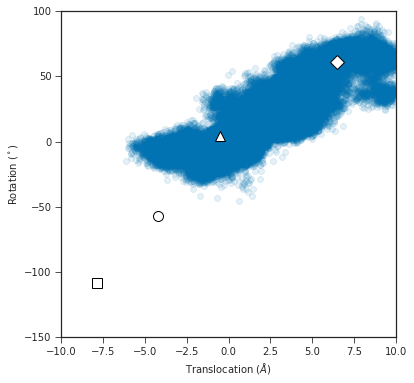

In [35]:
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(*cv_arr[::10].T, alpha=0.1)
util.format_cvs(ax, centroids=True)

In [36]:
sb_arr = sb_arr[points_ids]

In [15]:
from itertools import combinations

In [17]:
sb_ids = [48, 54, 53, 59]

In [19]:
feat2_models = np.load("../../data/models_centroids_feat2.npy")

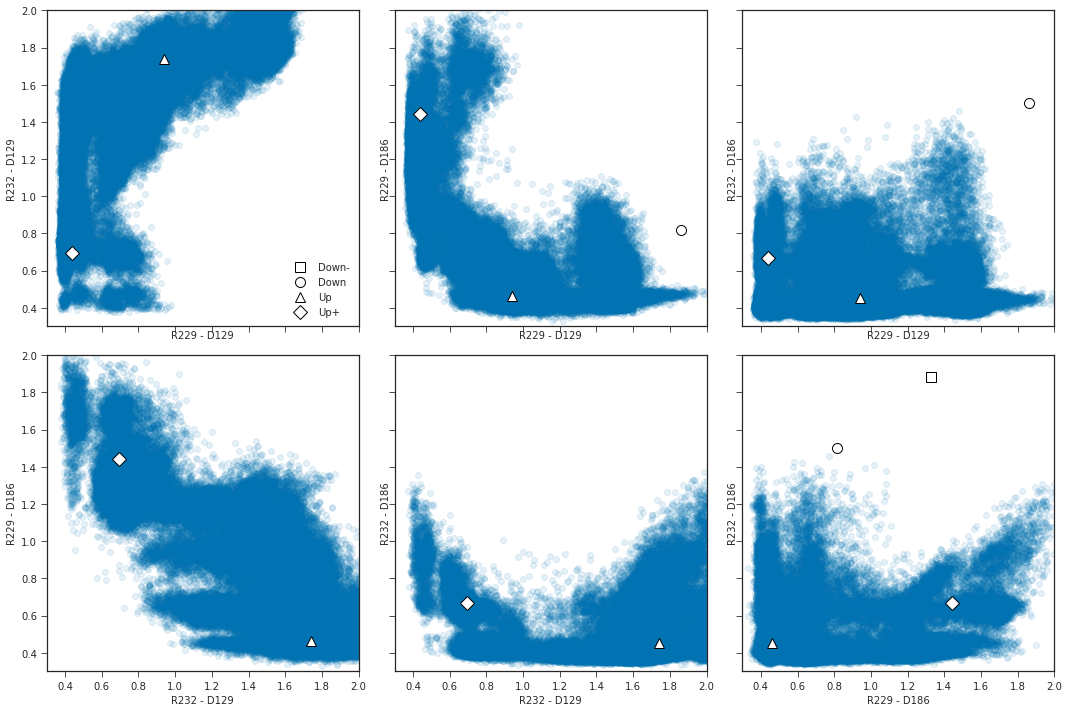

In [37]:
f, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
# 100 ns lag
s = 10
for ((sb1, sb2), ax) in zip(combinations(sb_ids, 2), axes.flat):
    ax.scatter(sb_arr[::s, sb1], sb_arr[::s, sb2], alpha=0.1)
    ax.set(xlabel=sb_labels[sb1 - 30], ylabel=sb_labels[sb2 - 30])

axes[0][0].set(xlim=[0.3, 2.0], ylim=[0.3, 2.0])
util.plot_models(axes[0][0], feat2_models[:, 48:55:6])  # indexes 48 and 54
util.plot_models(axes[0][1], feat2_models[:, 48:54:5])  # 48 and 53
util.plot_models(axes[0][2], feat2_models[:, 48:60:11])  # 48 and 59
util.plot_models(axes[1][0], feat2_models[:, 54:52:-1])  # indexes 54 and 53
util.plot_models(axes[1][1], feat2_models[:, 54:60:5])  # 54 and 59
util.plot_models(axes[1][2], feat2_models[:, 53:60:6])  # 53 and 59
axes[0][0].legend(["Down-", "Down", "Up", "Up+"])

f.tight_layout()

In [38]:
livac_arr = livac_arr[points_ids]

# DGA calculations

## States 

In [11]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
tic1 = livac_arr[:, 1]
tic2 = livac_arr[:, 2]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 48]  # R229-D129
sb3 = sb_arr[:, 53]  # R229-D186
sb4 = sb_arr[:, 54]  # R4 - D129

# ellipse centered at (-0.506, 3.94) with radii 0.84 nm and 7.6 deg (2 sigma in each direction) for up state
# take points where TIC 2 > -1.0 and R3/R4-D129 salt bridges < 0.5/> 0.6 nm, R3-D186 < 0.55
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb2 > 0.6)
    & (sb3 < 0.55)
    & (tic2 > -1)
).nonzero()[0]

# ellipse centered at (6.447, 60.713) with radii 0.632 and 2.9 for up+ state
# take points where TIC 1 < -1.25
dist_ax_upp = (dist - 6.447) / 0.632
rot_ax_upp = (rot - 60.713) / 4.0
upplus_ids = (
    ((dist_ax_upp ** 2 + rot_ax_upp ** 2) < 1) & (tic1 < -1.25) & (sb4 < 1.0)
).nonzero()[0]

In [12]:
mask = np.ones(len(cv_arr), dtype=bool)
mask[upplus_ids] = False
mask[up_ids] = False

# len(**_ids) is number of points in each state
# upplus = data_arr[upplus_ids]
# up = data_arr[up_ids]
# other = data_arr[mask]

# split CV data
upplus_cvs = cv_arr[upplus_ids]
up_cvs = cv_arr[up_ids]
other_cvs = cv_arr[mask]
upplus_sbs = sb_arr[upplus_ids]
up_sbs = sb_arr[up_ids]
other_sbs = cv_arr[mask]

In [13]:
assert (len(upplus_cvs) + len(up_cvs) + len(other_cvs)) == len(cv_arr)
print(f"Number of up+ structures:  {len(upplus_cvs)}")
print(f"Number of up structures:   {len(up_cvs)}")
print(f"Number of other structures: {len(other_cvs)}")

Number of up+ structures:  6946
Number of up structures:   3396
Number of other structures: 2989658


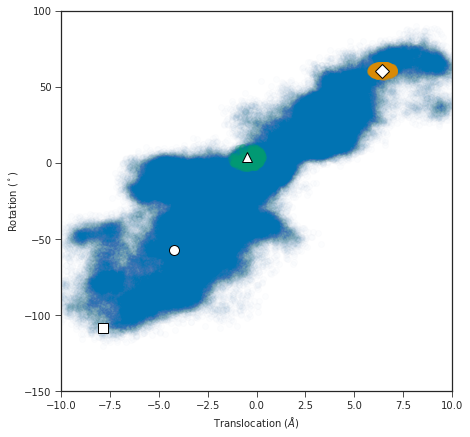

In [14]:
f = plt.figure(figsize=(7, 7))
ax = f.add_subplot(111)
s = 10
ax.scatter(cv_arr[::s, 0], cv_arr[::s, 1], alpha=0.01)
ax.scatter(upplus_cvs[::s, 0], upplus_cvs[::s, 1], alpha=0.2)
ax.scatter(up_cvs[::s, 0], up_cvs[::s, 1], alpha=0.2)
util.format_cvs(ax, centroids=True)

## Basis set construction

In [15]:
feat5_ivac_trajs = np.load(
    "../../data/raw_feat/feat5_ivac_anton.npy", allow_pickle=True
)

In [16]:
feat5_ivac_arr = np.concatenate(feat5_ivac_trajs)
print(feat5_ivac_arr.shape)

(3000000, 10)


In [17]:
# cluster
km = pyemma.coordinates.cluster_mini_batch_kmeans(
    data=feat5_ivac_arr, k=1000, max_iter=100, n_jobs=36
)
dtrajs = km.dtrajs[0]

14-07-21 10:11:11 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[0] INFO     Cluster centers converged after 9 steps.


In [18]:
np.save("../../data/raw_feat/feat5_ivac_ind1000", dtrajs)

In [53]:
import pickle

In [54]:
with open("../../data/kmeans_feat5_ivac_1000.pkl", mode="wb+") as f:
    pickle.dump(km, f)

In [55]:
km.cluster_centers_.shape

(1000, 10)

In [57]:
%matplotlib inline

In [62]:
# find closest point to cluster centers
args = np.empty(1000)
for i in range(1000):
    dists = np.linalg.norm(feat5_ivac_arr - km.cluster_centers_[i], axis=1)
    arg = np.argmin(dists)
    args[i] = arg

In [66]:
args = args.astype(int)

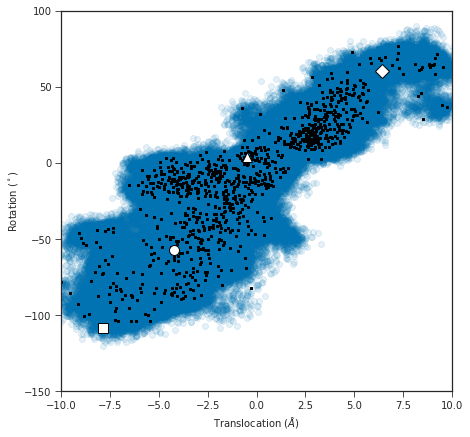

In [72]:
# plot clusters
cv_clusters = cv_arr[args]
f, ax = plt.subplots(figsize=(7, 7))
ax.scatter(*cv_arr[::10].T, alpha=0.1)
ax.plot(*cv_clusters.T, "sk", ms=2)
util.format_cvs(ax, centroids=True)

In [19]:
from scipy import sparse

In [20]:
# assemble basis using sparse matrices
nclusters = 1000

rows, cols = [], []
for i in range(nclusters):
    pts = np.argwhere(dtrajs == i)
    # indices of which frames are in the cluster i
    rows.append(pts.squeeze())
    # all assigned as 1 in the basis
    cols.append(np.repeat(i, len(pts)))
rows = np.hstack(rows)
cols = np.hstack(cols)
data = np.ones(len(rows), dtype=float)
basis = sparse.csr_matrix((data, (rows, cols)), shape=(len(cv_arr), nclusters))

In [21]:
# enforce boundary conditions for committor calculations
basisF_arr = basis
basisF_arr[up_ids] = 0
basisF_arr[upplus_ids] = 0

# remove basis functions which are completely 0 (i.e. entirely contained in A U B)
nonzero = np.where(np.sum(basisF_arr.A, axis=0) > 0)[0]
basisF_arr = basisF_arr[:, nonzero]
print(basisF_arr.shape)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


(3000000, 1000)


In [22]:
traj_lens = [len(traj) for traj in cv_trajs]
traj_inds = []
subtot = 0
for length in traj_lens[:-1]:
    subtot += length
    traj_inds.append(subtot)

In [23]:
# split into lists of arrays
basisF, basisL = [], []
curr = 0
for t_len in traj_lens:
    basisF.append(basisF_arr[curr : curr + t_len])
    basisL.append(basis[curr : curr + t_len])
    curr += t_len
print(len(basisF), basisF[0].shape)
print(len(basisL), basisL[0].shape)

# guess functions
guess_upp = np.zeros(len(cv_arr))
guess_upp[upplus_ids] = 1
guessU = np.split(guess_upp, traj_inds)
guess_up = np.zeros(len(cv_arr))
guess_up[up_ids] = 1
guessD = np.split(guess_up, traj_inds)

237 (10000, 1000)
237 (10000, 1000)


## weights 

In [11]:
# unit is 0.1 ps, up to 500 ns
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]

In [16]:
weights = np.load("../../data/coms_feat5_ind200_anton.npy", allow_pickle=True)
weights = weights[:10]
print(len(weights), len(weights[0]), weights[0][0].shape)

10 237 (10000,)


## Committors

In [26]:
in_domain = np.split(mask, traj_inds)

In [27]:
q_downup, q_updown, qb_downup, qb_updown = [], [], [], []
for (lag, com) in zip(lags, weights):
    print(f"Calculating committors for lag {lag}")
    q_downup.append(
        extq.dga.forward_committor_sparse(basisF, com, in_domain, guessU, lag)
    )
    qb_downup.append(
        extq.dga.backward_committor_sparse(basisF, com, in_domain, guessD, lag)
    )
    q_updown.append(
        extq.dga.forward_committor_sparse(basisF, com, in_domain, guessD, lag)
    )
    qb_updown.append(
        extq.dga.backward_committor_sparse(basisF, com, in_domain, guessU, lag)
    )

Calculating committors for lag 1
Calculating committors for lag 2
Calculating committors for lag 5
Calculating committors for lag 10
Calculating committors for lag 20
Calculating committors for lag 50
Calculating committors for lag 100
Calculating committors for lag 200
Calculating committors for lag 500
Calculating committors for lag 1000
Calculating committors for lag 2000


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


Calculating committors for lag 5000


SystemError: <built-in function gssv> returned a result with an error set

In [28]:
len(q_downup)

11

In [30]:
np.save("../../data/feat5_tica_ind1000_uu/q_downup", q_downup)
np.save("../../data/feat5_tica_ind1000_uu/qb_downup", qb_downup)
np.save("../../data/feat5_tica_ind1000_uu/q_updown", q_updown)
np.save("../../data/feat5_tica_ind1000_uu/qb_updown", qb_updown)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [12]:
q_downup = np.load("../../data/feat5_tica_ind1000_uu/q_downup.npy", allow_pickle=True)
qb_downup = np.load("../../data/feat5_tica_ind1000_uu/qb_downup.npy", allow_pickle=True)
q_updown = np.load("../../data/feat5_tica_ind1000_uu/q_updown.npy", allow_pickle=True)
qb_updown = np.load("../../data/feat5_tica_ind1000_uu/qb_updown.npy", allow_pickle=True)

## Plot 

### all lags

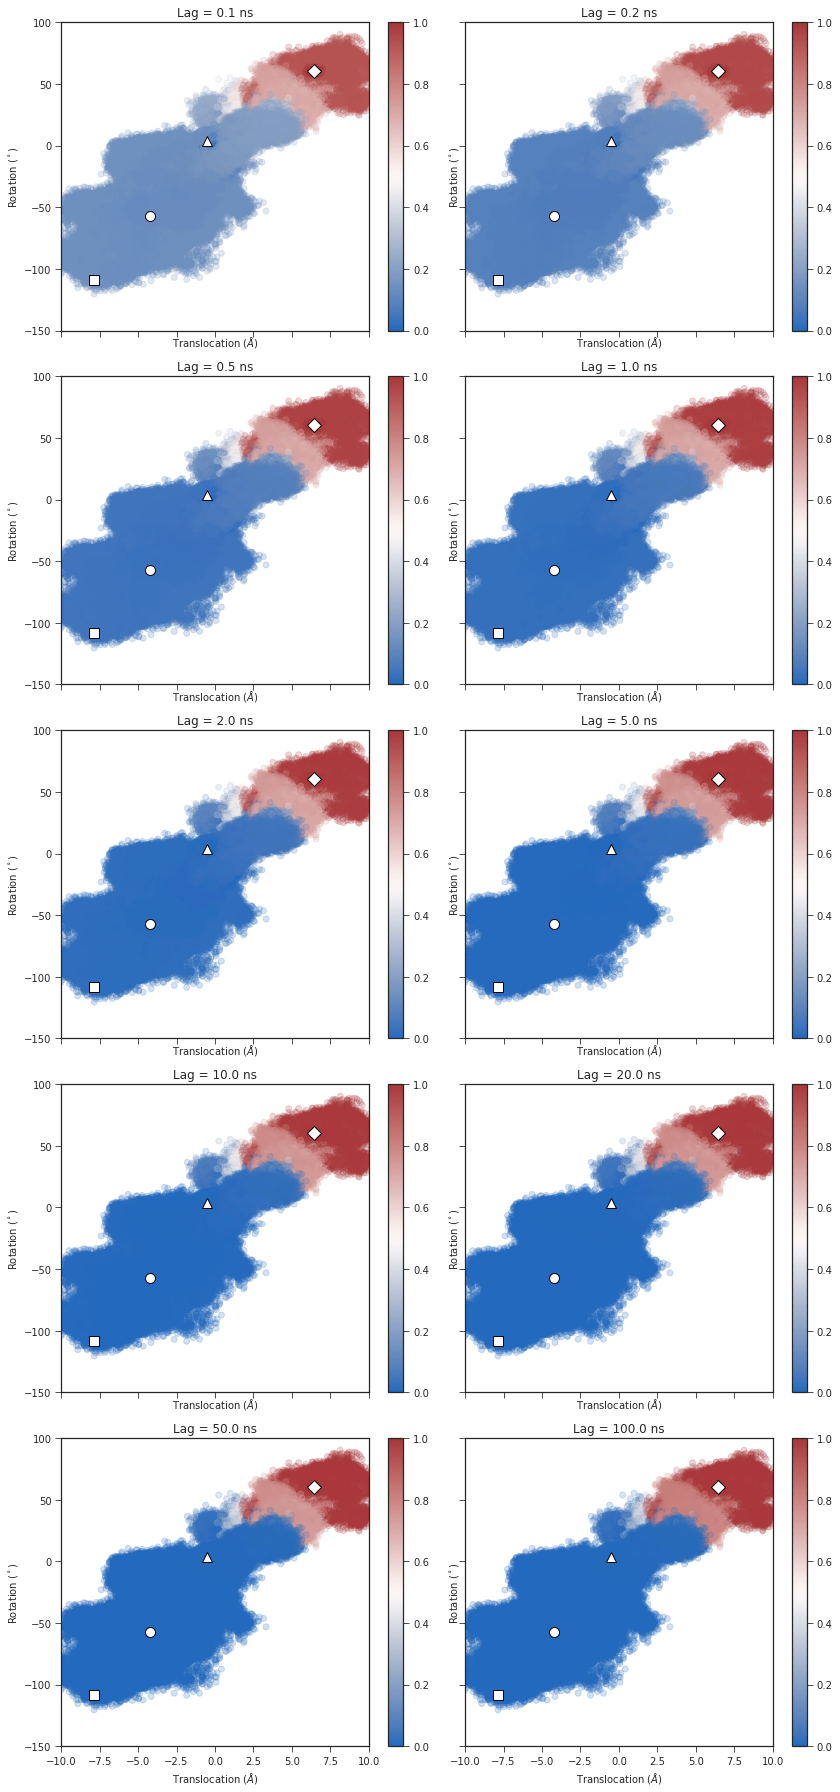

In [31]:
s = 10
f, axs = plt.subplots(5, 2, figsize=(12, 25), sharex=True, sharey=True)
for lag, q, ax in zip(lags[:10], q_downup[:10], axs.flatten()):
    q_arr = np.concatenate(q).clip(min=0.0, max=1.0)
    h = ax.scatter(*cv_arr[::s].T, c=q_arr[::s], cmap="vlag", alpha=0.2)
    cbar = plt.colorbar(h, ax=ax)
    cbar.solids.set(alpha=1)
    ax.set_title(f"Lag = {lag * 0.1} ns")
    util.format_cvs(ax, centroids=True)
f.tight_layout()

In [13]:
from itertools import combinations

In [14]:
sb_ids = [48, 54, 53, 59]
feat2_models = np.load("../../data/models_centroids_feat2.npy")

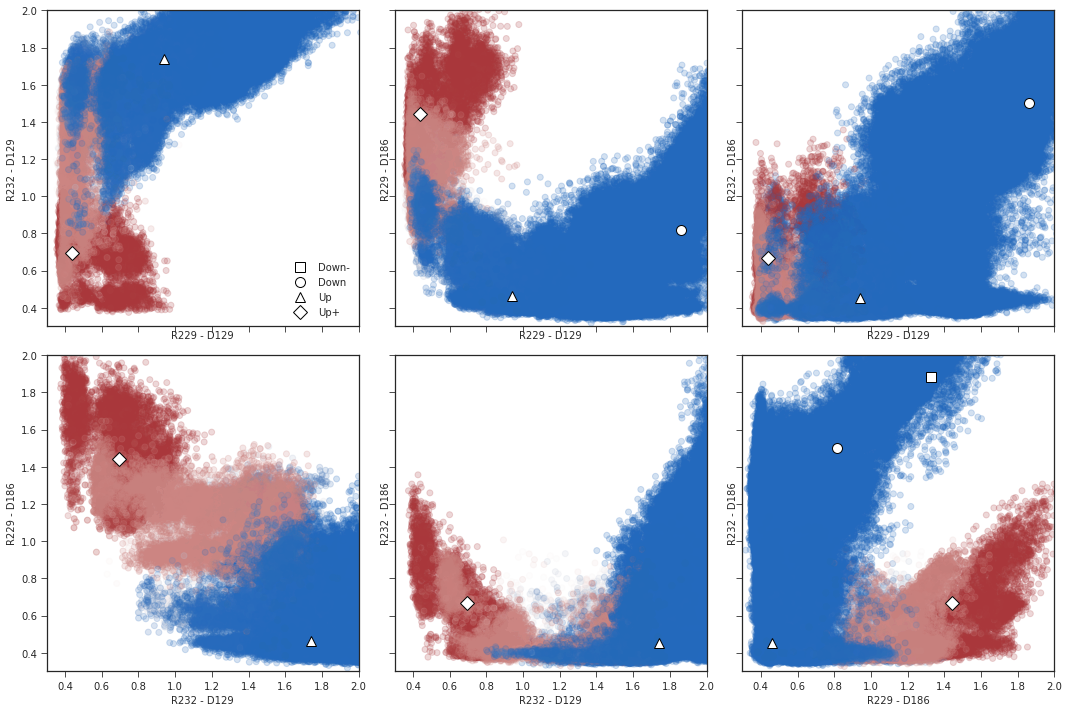

In [34]:
f, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
# 100 ns lag
s = 10
q_arr = np.concatenate(q_downup[9]).clip(min=0.0, max=1.0)
for ((sb1, sb2), ax) in zip(combinations(sb_ids, 2), axes.flat):
    ax.scatter(sb_arr[::s, sb1], sb_arr[::s, sb2], c=q_arr[::s], cmap="vlag", alpha=0.2)
    ax.set(xlabel=sb_labels[sb1 - 30], ylabel=sb_labels[sb2 - 30])

axes[0][0].set(xlim=[0.3, 2.0], ylim=[0.3, 2.0])
util.plot_models(axes[0][0], feat2_models[:, 48:55:6])  # indexes 48 and 54
util.plot_models(axes[0][1], feat2_models[:, 48:54:5])  # 48 and 53
util.plot_models(axes[0][2], feat2_models[:, 48:60:11])  # 48 and 59
util.plot_models(axes[1][0], feat2_models[:, 54:52:-1])  # indexes 54 and 53
util.plot_models(axes[1][1], feat2_models[:, 54:60:5])  # 54 and 59
util.plot_models(axes[1][2], feat2_models[:, 53:60:6])  # 53 and 59
axes[0][0].legend(["Down-", "Down", "Up", "Up+"])

f.tight_layout()

In [17]:
import plotting

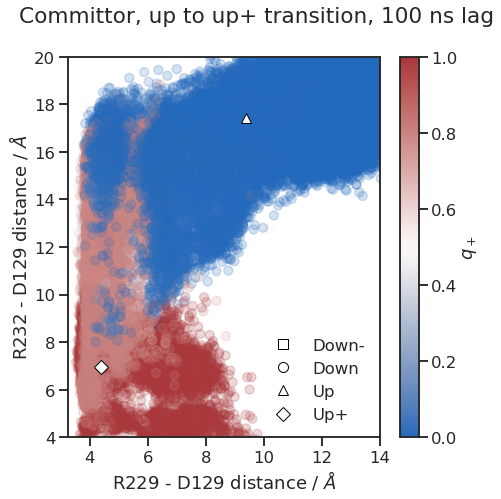

In [19]:
# figure for talk
sns.set_context("talk")
f, ax = plt.subplots(figsize=(7, 7))
q_arr = np.concatenate(q_downup[9])  # 100 ns lag
sb1, sb2 = sb_ids[:2]
h = ax.scatter(
    sb_arr[::10, sb1] * 10,  # convert to Angstroms
    sb_arr[::10, sb2] * 10,
    c=q_arr[::10],
    cmap="vlag",
    alpha=0.2,
)
ax.set(
    xlabel=f"{sb_labels[sb1 - 30]} distance / $\AA$",
    ylabel=f"{sb_labels[sb2 - 30]} distance / $\AA$",
)
ax.set(xlim=[3.25, 14], ylim=[4, 20])
plotting.plot_models(ax, feat2_models[:, sb1 : (sb2 + 1) : (sb2 - sb1)] * 10)
cbar = plt.colorbar(h, ax=ax, label="$q_+$")
cbar.solids.set(alpha=1)
ax.legend(["Down-", "Down", "Up", "Up+"], loc="lower right")
f.suptitle("Committor, up to up+ transition, 100 ns lag")
plt.savefig("../../fig/committors/qf_uu_r3d129_r4d129_lag1000_ind1000.png", dpi=400)

In [35]:
import pickle

In [36]:
with open("../../data/livac-feat2-anton.pkl", mode="rb") as f:
    livac = pickle.load(f)
ivac_models = livac.transform([feat2_models])[0]

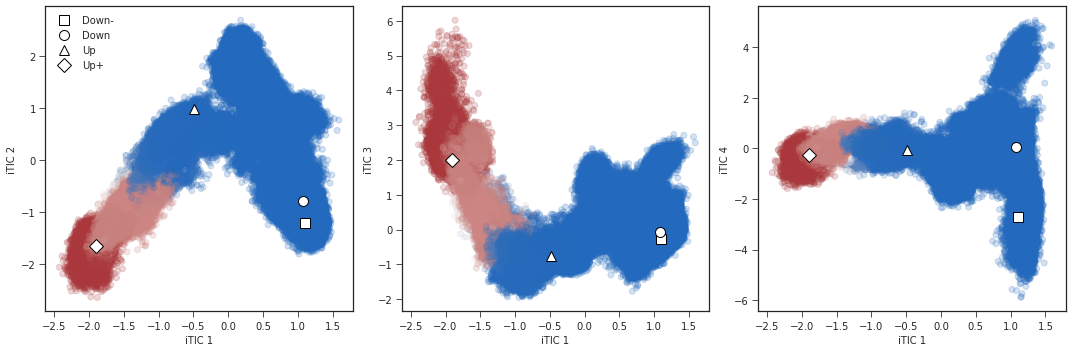

In [37]:
f, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
q_arr = np.concatenate(q_downup[9]).clip(min=0.0, max=1.0)
for i, ax in enumerate(axes):
    ax.scatter(
        ivac_arr[::s, 1], ivac_arr[::s, i + 2], c=q_arr[::s], cmap="vlag", alpha=0.2
    )
    ax.set(xlabel=f"iTIC 1", ylabel=f"iTIC {i + 2}")
util.plot_models(axes[0], ivac_models[:, 1:3])
util.plot_models(axes[1], ivac_models[:, 1:4:2])
util.plot_models(axes[2], ivac_models[:, 1:5:3])
axes[0].legend(["Down-", "Down", "Up", "Up+"], loc="upper left")

f.tight_layout()

### 3d projections

In [73]:
%matplotlib notebook

In [15]:
centroids = np.loadtxt("../../models/MD-clustering-center/all.txt")

<IPython.core.display.Javascript object>


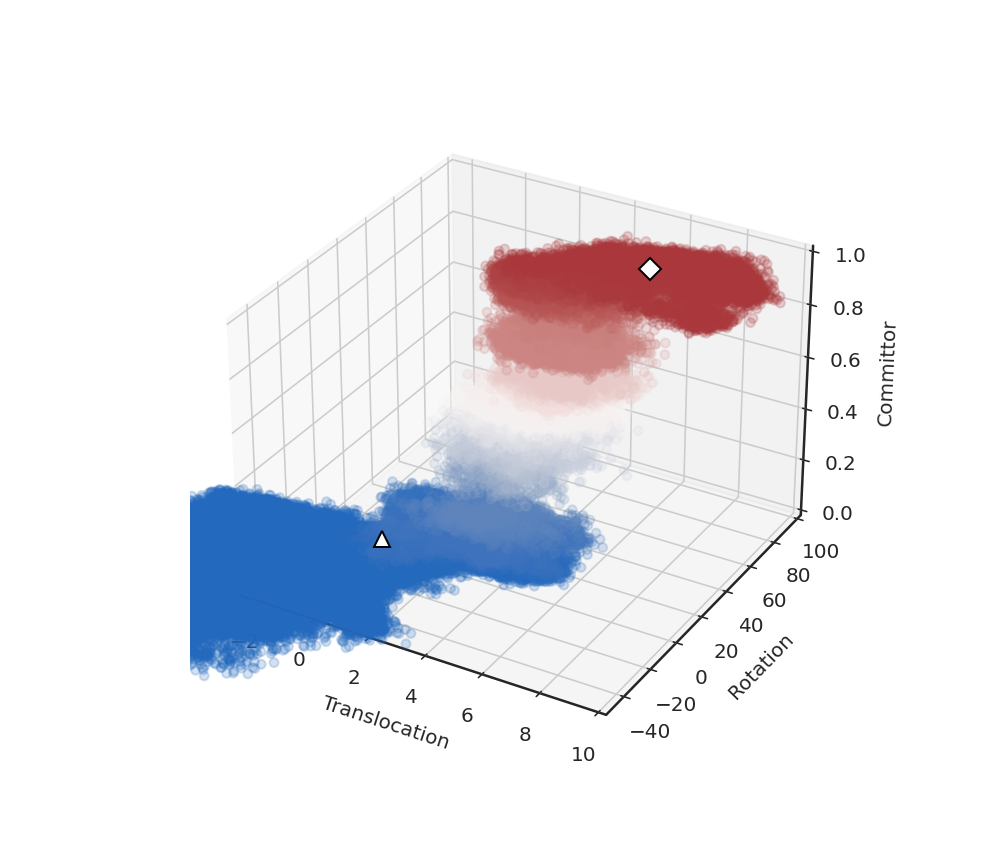

In [46]:
f = plt.figure(figsize=(7, 6))
ax = f.add_subplot(projection="3d")

s = 10
q = np.concatenate(q_downup[9]).clip(min=0, max=1)
ax.scatter(cv_arr[::s, 0], cv_arr[::s, 1], q[::s], c=q[::10], cmap="vlag", alpha=0.2)
ax.set_xlabel("Translocation")
ax.set_ylabel("Rotation")
ax.set_zlabel("Committor")
ax.set_xlim([-2.5, 10])
ax.set_ylim([-50, 100])
ax.set_zlim([0, 1.0])

ax.plot(centroids[3, 0], centroids[3, 1], 1, "D", mec="k", mfc="w", ms=8)
ax.plot(centroids[2, 0], centroids[2, 1], 0, "^", mec="k", mfc="w", ms=8)

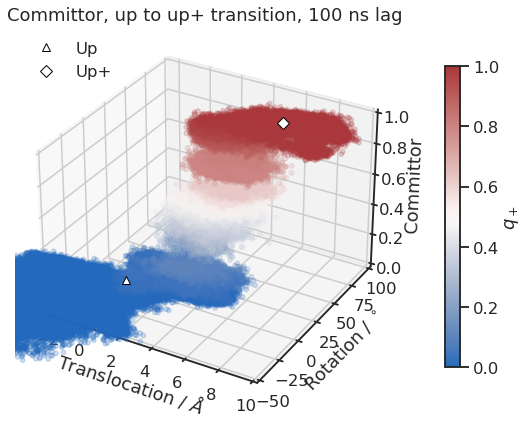

In [21]:
f = plt.figure(figsize=(9, 7))
ax = f.add_subplot(projection="3d")

s = 10
q = np.concatenate(q_downup[9]).clip(min=0, max=1)
ax.scatter(cv_arr[::s, 0], cv_arr[::s, 1], q[::s], c=q[::10], cmap="vlag", alpha=0.2)
ax.set_xlabel("Translocation / $\AA$")
ax.set_ylabel("Rotation / $^\circ$")
ax.set_zlabel("Committor")
ax.set_xlim([-2.5, 10])
ax.set_ylim([-50, 100])
ax.set_zlim([0, 1.0])
cbar = plt.colorbar(h, ax=ax, pad=0.1, fraction=0.03, label="$q_+$")
cbar.solids.set(alpha=1)
ax.set_title("Committor, up to up+ transition, 100 ns lag")

ax.plot(centroids[2, 0], centroids[2, 1], 0, "^", mec="k", mfc="w", ms=8)
ax.plot(centroids[3, 0], centroids[3, 1], 1, "D", mec="k", mfc="w", ms=8)
ax.legend(["Up", "Up+"], loc="upper left")

plt.savefig("../../fig/committors/qf_uu_dsq_lag1000_ind1000.png", dpi=400)

<IPython.core.display.Javascript object>


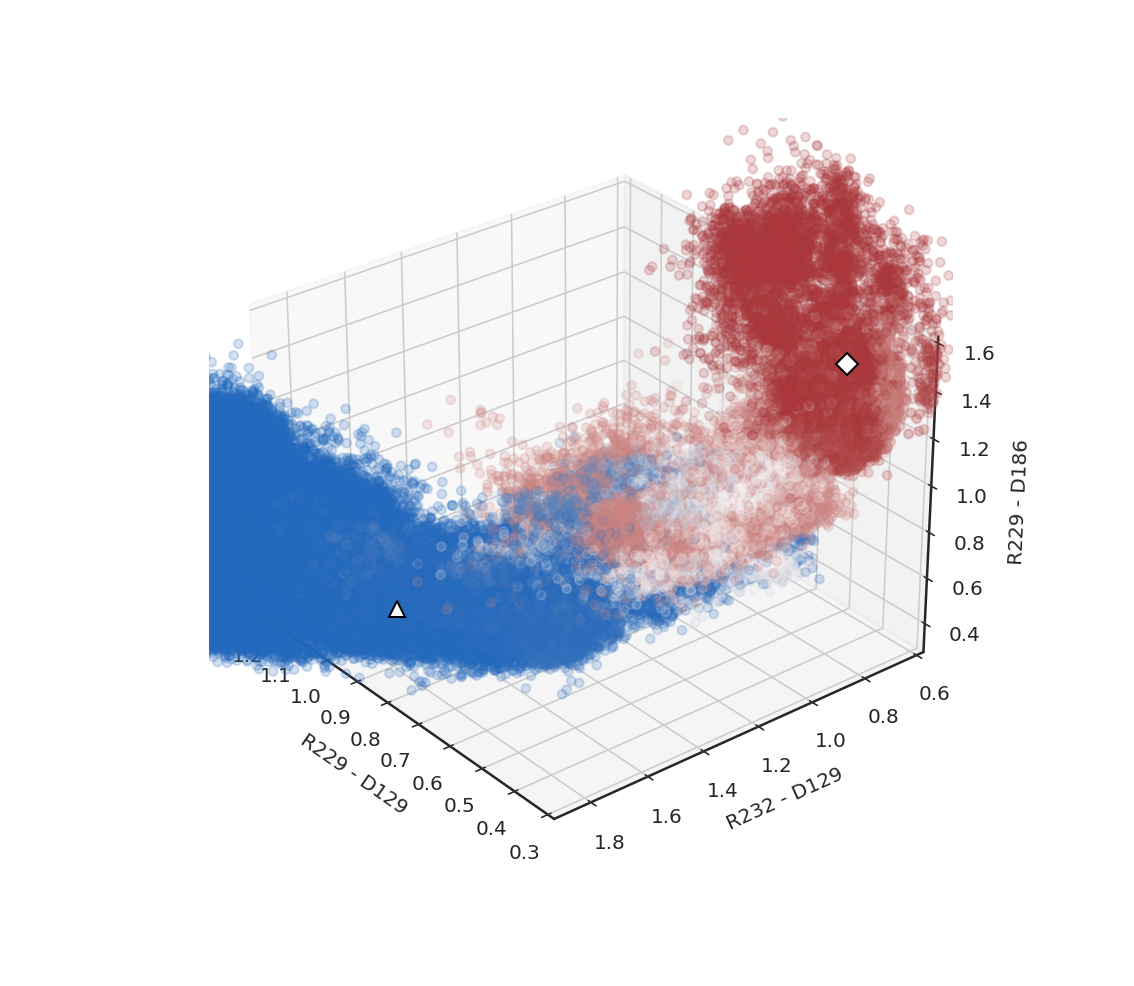

In [74]:
f = plt.figure(figsize=(7, 6))
ax = f.add_subplot(projection="3d")

q = np.concatenate(q_downup[9]).clip(min=0, max=1)
ax.scatter(
    sb_arr[::10, sb_ids[0]],
    sb_arr[::10, sb_ids[1]],
    sb_arr[::10, sb_ids[2]],
    c=q[::10],
    cmap="vlag",
    alpha=0.2,
)
ax.set_xlabel(sb_labels[sb_ids[0] - 30])
ax.set_ylabel(sb_labels[sb_ids[1] - 30])
ax.set_zlabel(sb_labels[sb_ids[2] - 30])
ax.set_xlim([0.3, 1.2])
ax.set_ylim([0.6, 1.9])
ax.set_zlim([0.3, 1.6])

ax.plot(
    feat2_models[3, sb_ids[0]],
    feat2_models[3, sb_ids[1]],
    feat2_models[3, sb_ids[2]],
    "D",
    mec="k",
    mfc="w",
    ms=8,
)
ax.plot(
    feat2_models[2, sb_ids[0]],
    feat2_models[2, sb_ids[1]],
    feat2_models[2, sb_ids[2]],
    "^",
    mec="k",
    mfc="w",
    ms=8,
)
ax.view_init(elev=20, azim=140)

plt.show()

<IPython.core.display.Javascript object>


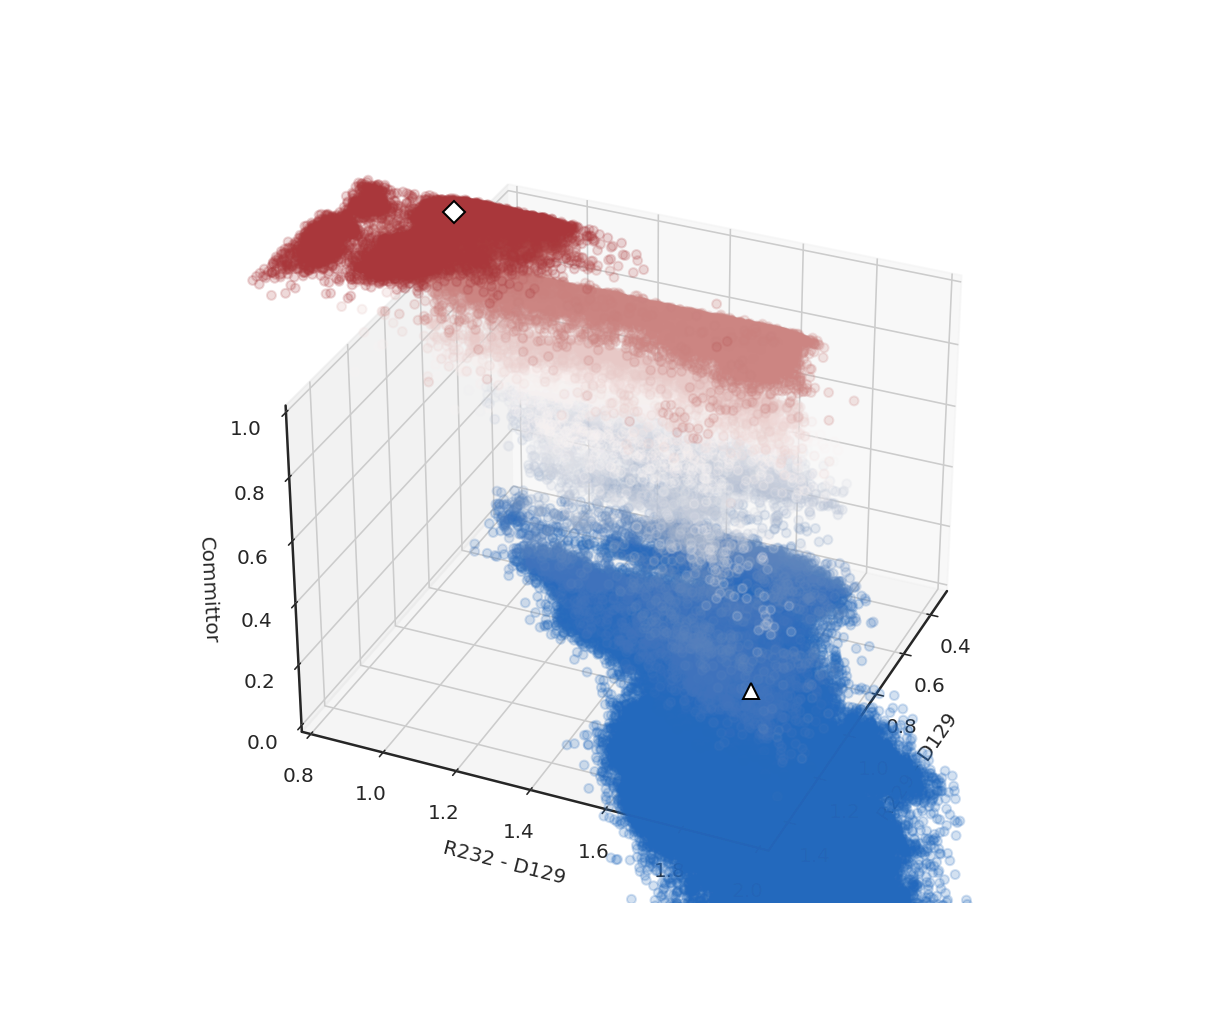

In [78]:
f = plt.figure(figsize=(7, 6))
ax = f.add_subplot(projection="3d")

s = 10
q = np.concatenate(q_downup[9]).clip(min=0, max=1)
ax.scatter(
    sb_arr[::s, sb_ids[0]],
    sb_arr[::s, sb_ids[1]],
    q[::s],
    c=q[::10],
    cmap="vlag",
    alpha=0.2,
)
ax.set_xlabel(f"{sb_labels[sb_ids[0] - 30]}")
ax.set_ylabel(f"{sb_labels[sb_ids[1] - 30]}")
ax.set_zlabel("Committor")
ax.set_xlim([0.3, 1.5])
ax.set_ylim([0.8, 2.0])
ax.set_zlim([0, 1.0])
ax.view_init(elev=25, azim=60)

ax.plot(
    feat2_models[3, sb_ids[0]],
    feat2_models[3, sb_ids[1]],
    1,
    "D",
    mec="k",
    mfc="w",
    ms=8,
)
ax.plot(
    feat2_models[2, sb_ids[0]],
    feat2_models[2, sb_ids[1]],
    0,
    "^",
    mec="k",
    mfc="w",
    ms=8,
)

ax.view_init(elev=25, azim=15)

plt.show()

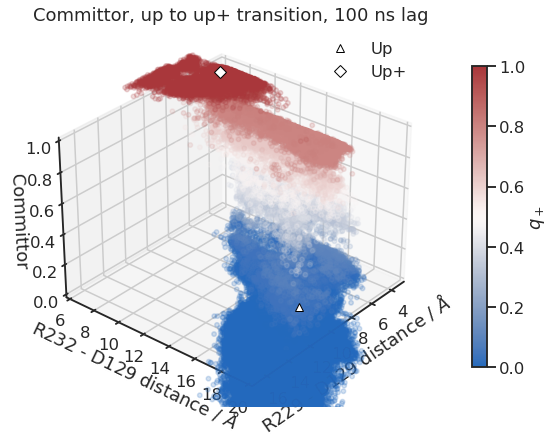

In [24]:
f = plt.figure(figsize=(9, 7))
ax = f.add_subplot(projection="3d")

s = 10
q = np.concatenate(q_downup[9]).clip(min=0, max=1)
ax.scatter(
    sb_arr[::s, sb_ids[0]] * 10,
    sb_arr[::s, sb_ids[1]] * 10,
    q[::s],
    c=q[::10],
    cmap="vlag",
    alpha=0.2,
)
ax.set_xlabel(f"{sb_labels[sb_ids[0] - 30]} distance / $\AA$")
ax.set_ylabel(f"{sb_labels[sb_ids[1] - 30]} distance / $\AA$")
ax.set_zlabel("Committor")
ax.set_xlim([3, 17])
ax.set_ylim([6, 20])
ax.set_zlim([0, 1.0])
cbar = plt.colorbar(h, ax=ax, pad=0.1, fraction=0.03, label="$q_+$")
cbar.solids.set(alpha=1)
ax.set_title("Committor, up to up+ transition, 100 ns lag")


ax.plot(
    feat2_models[2, sb_ids[0]] * 10,
    feat2_models[2, sb_ids[1]] * 10,
    0,
    "^",
    mec="k",
    mfc="w",
    ms=8,
)
ax.plot(
    feat2_models[3, sb_ids[0]] * 10,
    feat2_models[3, sb_ids[1]] * 10,
    1,
    "D",
    mec="k",
    mfc="w",
    ms=8,
)
ax.legend(["Up", "Up+"], loc="upper right")

ax.view_init(azim=40, elev=30)

plt.savefig("../../fig/committors/qf_uu_r3r4q_lag1000_ind1000.png", dpi=400)

<IPython.core.display.Javascript object>


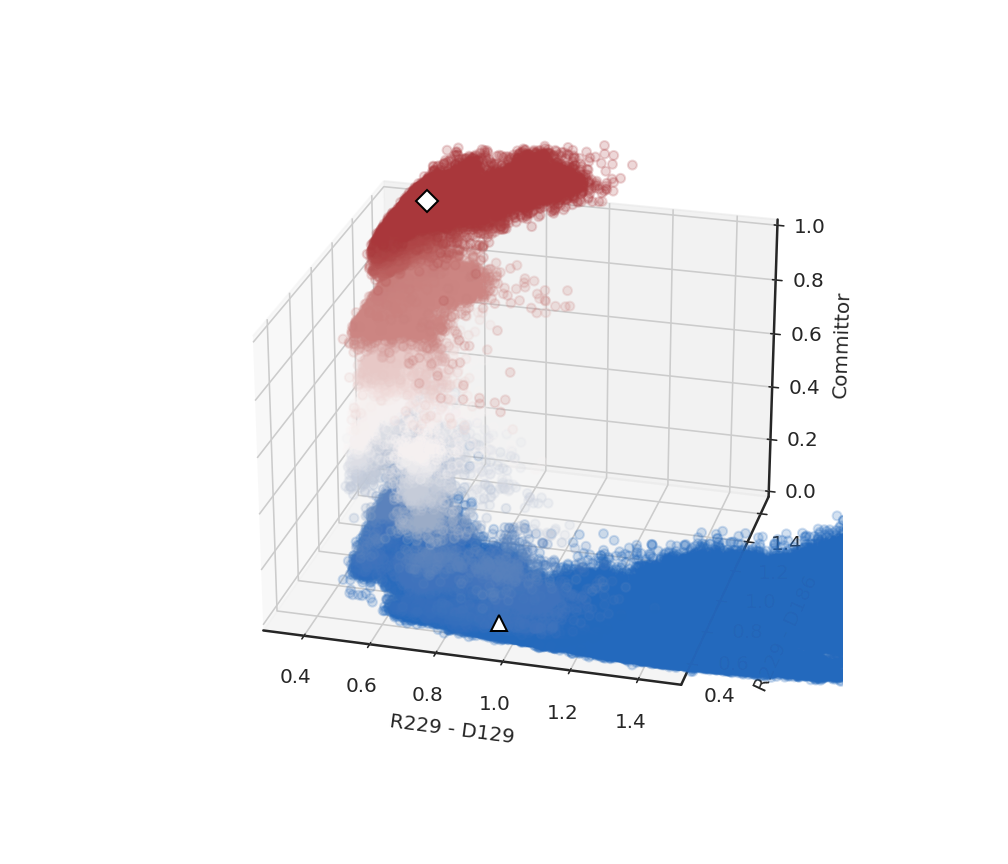

In [83]:
f = plt.figure(figsize=(7, 6))
ax = f.add_subplot(projection="3d")

s = 10
q = np.concatenate(q_downup[9]).clip(min=0, max=1)
ax.scatter(
    sb_arr[::s, sb_ids[0]],
    sb_arr[::s, sb_ids[2]],
    q[::s],
    c=q[::10],
    cmap="vlag",
    alpha=0.2,
)
ax.set_xlabel(f"{sb_labels[sb_ids[0] - 30]}")
ax.set_ylabel(f"{sb_labels[sb_ids[2] - 30]}")
ax.set_zlabel("Committor")
ax.set_xlim([0.3, 1.5])
ax.set_ylim([0.3, 1.5])
ax.set_zlim([0, 1.0])

ax.plot(
    feat2_models[3, sb_ids[0]],
    feat2_models[3, sb_ids[2]],
    1,
    "D",
    mec="k",
    mfc="w",
    ms=8,
)
ax.plot(
    feat2_models[2, sb_ids[0]],
    feat2_models[2, sb_ids[2]],
    0,
    "^",
    mec="k",
    mfc="w",
    ms=8,
)

ax.view_init(elev=25, azim=-75)

plt.show()

### Transition state region

In [19]:
q = np.concatenate(q_downup[9])
ids = np.argsort((q - 0.5) ** 2)
for i in ids[:40]:
    print(f"{util.anton_frame(i)}: {cv_arr[i]}, {q[i]}")

(84, 5435): [ 2.808 39.121], 0.5002276360236954
(92, 8001): [ 3.419 25.855], 0.5002276360236954
(92, 7999): [ 3.207 29.505], 0.5002276360236954
(142, 1841): [ 4.266 37.771], 0.5002276360236954
(92, 7997): [ 3.104 30.186], 0.5002276360236954
(92, 7996): [ 3.346 29.371], 0.5002276360236954
(92, 7994): [ 3.413 30.021], 0.5002276360236954
(92, 7992): [ 3.708 26.691], 0.5002276360236954
(92, 7989): [ 3.377 35.258], 0.5002276360236954
(142, 1844): [ 4.    34.393], 0.5002276360236954
(92, 8002): [ 3.29  30.623], 0.5002276360236954
(142, 1845): [ 3.978 38.003], 0.5002276360236954
(92, 7981): [ 3.399 26.511], 0.5002276360236954
(84, 2911): [ 4.001 33.42 ], 0.5002276360236954
(142, 1855): [ 3.371 40.195], 0.5002276360236954
(92, 7962): [ 3.377 22.704], 0.5002276360236954
(84, 2912): [ 3.713 31.305], 0.5002276360236954
(142, 1857): [ 4.258 37.532], 0.5002276360236954
(84, 1620): [ 3.01  32.587], 0.5002276360236954
(92, 4193): [ 2.224 27.873], 0.5002276360236954
(92, 4192): [ 1.748 29.26 ], 0.5002

In [87]:
%matplotlib inline

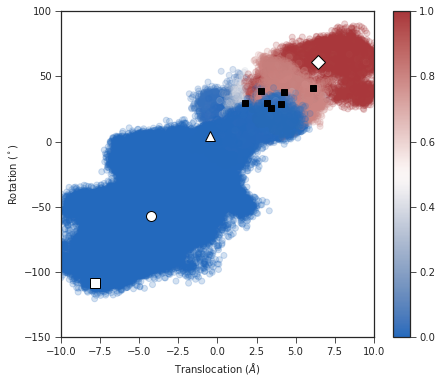

In [89]:
f, ax = plt.subplots(figsize=(7, 6))
h = ax.scatter(*cv_arr[::s].T, c=q[::s], cmap="vlag", alpha=0.2)
plot = [0, 1, 3, 20, 24, 25, 27]
for i in ids[plot]:
    ax.plot(*cv_arr[i].T, "sk")
cbar = plt.colorbar(h, ax=ax)
cbar.solids.set(alpha=1)
util.format_cvs(ax, centroids=True)

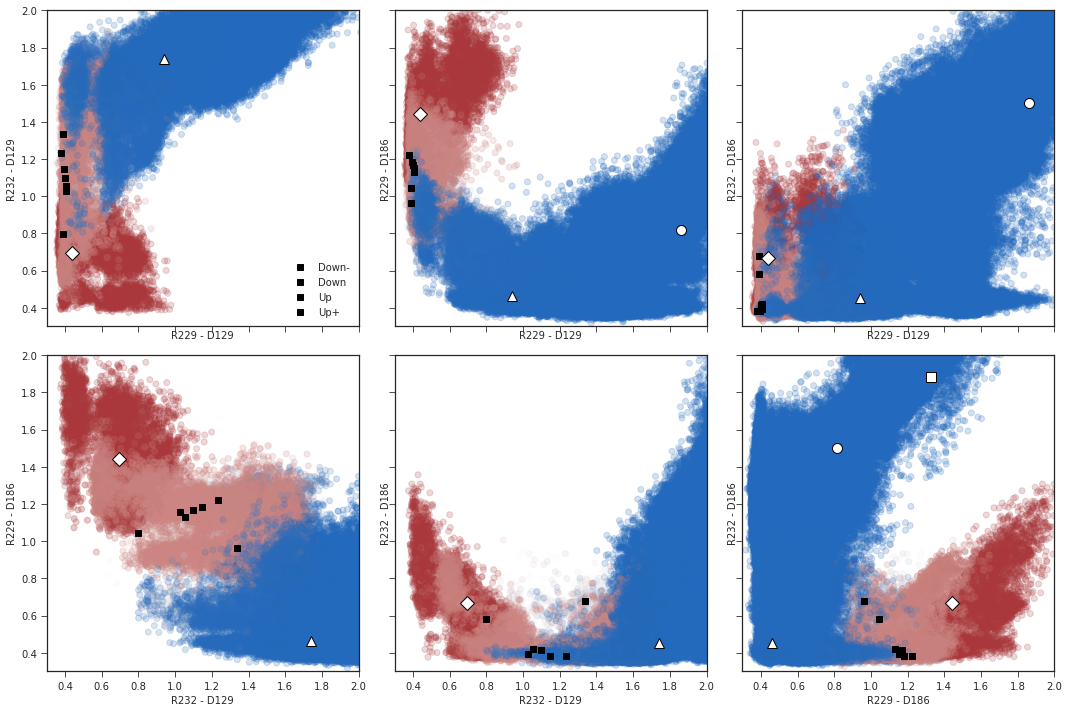

In [91]:
f, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
# 100 ns lag
s = 10
for ((sb1, sb2), ax) in zip(combinations(sb_ids, 2), axes.flat):
    ax.scatter(sb_arr[::s, sb1], sb_arr[::s, sb2], c=q[::s], cmap="vlag", alpha=0.2)
    for i in ids[plot]:
        ax.plot(sb_arr[i, sb1], sb_arr[i, sb2], "sk")
    ax.set(xlabel=sb_labels[sb1 - 30], ylabel=sb_labels[sb2 - 30])

axes[0][0].set(xlim=[0.3, 2.0], ylim=[0.3, 2.0])
util.plot_models(axes[0][0], feat2_models[:, 48:55:6])  # indexes 48 and 54
util.plot_models(axes[0][1], feat2_models[:, 48:54:5])  # 48 and 53
util.plot_models(axes[0][2], feat2_models[:, 48:60:11])  # 48 and 59
util.plot_models(axes[1][0], feat2_models[:, 54:52:-1])  # indexes 54 and 53
util.plot_models(axes[1][1], feat2_models[:, 54:60:5])  # 54 and 59
util.plot_models(axes[1][2], feat2_models[:, 53:60:6])  # 53 and 59
axes[0][0].legend(["Down-", "Down", "Up", "Up+"])

f.tight_layout()

In [92]:
ids[0]

845435

In [104]:
# transition state regions with higher value of R229-D129 distance?
tstate_ids = ((q > 0.49) & (q < 0.51)).nonzero()[0]
print(tstate_ids.shape)
for i in np.argsort(sb_arr[tstate_ids, 48])[:-20:-1]:
    print(
        f"{util.anton_frame(i)}: {cv_arr[tstate_ids[i]]}, {sb_arr[tstate_ids[i], 48]}, {q[tstate_ids[i]]}"
    )

(12240,)
(1, 100): [ 3.301 44.77 ], 1.098969578742981, 0.49967247280315025
(1, 108): [ 2.911 43.992], 1.0413960218429565, 0.49967247280315025
(1, 109): [ 2.796 41.699], 1.0276939868927002, 0.49967247280315025
(1, 105): [ 2.943 45.479], 1.015701174736023, 0.49967247280315025
(1, 107): [ 3.091 43.365], 1.0065710544586182, 0.49967247280315025
(1, 104): [ 2.581 45.568], 0.9971656799316406, 0.49967247280315025
(1, 111): [ 3.296 44.877], 0.9964964389801025, 0.49967247280315025
(1, 112): [ 2.809 47.381], 0.9910504817962646, 0.49967247280315025
(1, 106): [ 2.9   46.016], 0.9804167151451111, 0.49967247280315025
(1, 103): [ 3.649 40.852], 0.963224470615387, 0.49967247280315025
(1, 96): [ 3.135 39.381], 0.9247303009033203, 0.4949738756157633
(1, 98): [ 2.321 37.363], 0.9246329069137573, 0.4949738756157633
(1, 123): [ 3.055 34.886], 0.9022600054740906, 0.49967247280315025
(1, 101): [ 2.873 42.9  ], 0.9003627300262451, 0.49967247280315025
(0, 2918): [ 3.277 38.718], 0.8980796933174133, 0.4996724728

In [106]:
def test(X: np.ndarray) -> np.ndarray:
    return X

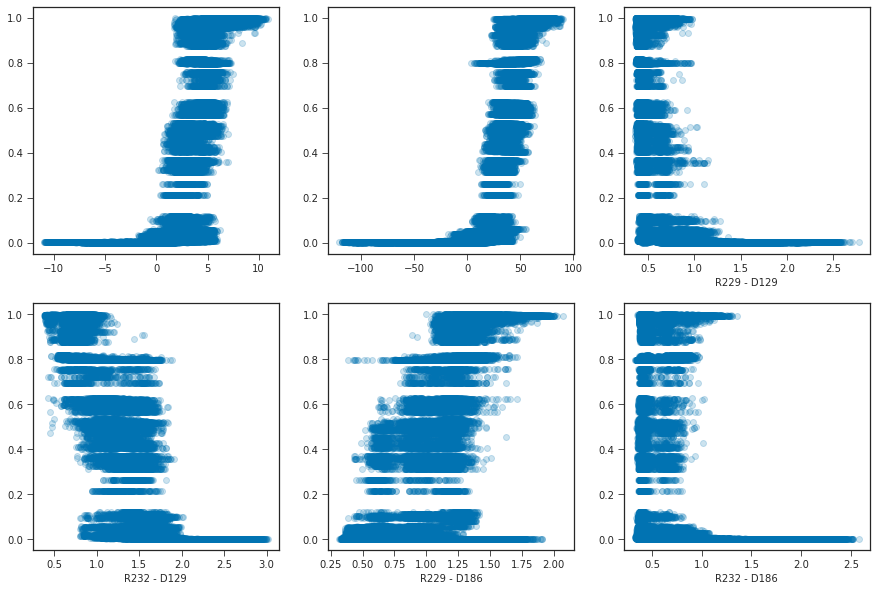

In [24]:
# plot correlation with all CVs
s = 10
q_arr = np.concatenate(q_downup[9])
f, axes = plt.subplots(2, 3, figsize=(15, 10))
axes.flat[0].scatter(cv_arr[::s, 0], q_arr[::s], alpha=0.2)
axes.flat[1].scatter(cv_arr[::s, 1], q_arr[::s], alpha=0.2)
for i in range(4):
    axes.flat[i + 2].scatter(sb_arr[::s, sb_ids[i]], q_arr[::s], alpha=0.2)
    axes.flat[i + 2].set(xlabel=f"{sb_labels[sb_ids[i] - 30]}")

### Histogrammed CVs

In [41]:
com = np.concatenate(weights[9])
q_dens, xe, ye = np.histogram2d(
    cv_arr[:, 0], cv_arr[:, 1], bins=100, density=False, weights=q_arr * com
)
w_dens, _, _ = np.histogram2d(
    cv_arr[:, 0], cv_arr[:, 1], bins=100, density=False, weights=com
)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


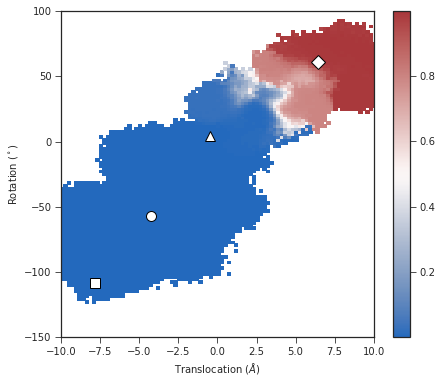

In [42]:
f, ax = plt.subplots(figsize=(7, 6))
h = ax.pcolor(xe, ye, (q_dens / w_dens).T, cmap="vlag")
plt.colorbar(h, ax=ax)
util.format_cvs(ax, centroids=True)

In [32]:
import kde

In [45]:
# kde
kd_estimate, xe, ye = kde.kdesum2d(
    cv_arr[:, 0], cv_arr[:, 1], q_arr * com, xmin=-2.5, xmax=10.0, ymin=-50, ymax=100
)
kde_w, _, _ = kde.kdesum2d(
    cv_arr[:, 0],
    cv_arr[:, 1],
    com,
    xmin=-2.5,
    xmax=10.0,
    ymin=-50,
    ymax=100,
)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


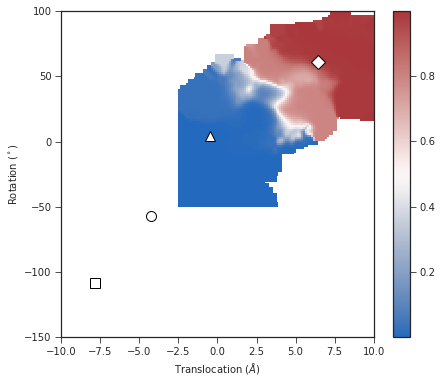

In [46]:
f, ax = plt.subplots(figsize=(7, 6))
h = ax.pcolor(xe, ye, (kd_estimate / kde_w).T, cmap="vlag")
plt.colorbar(h, ax=ax)
util.format_cvs(ax, centroids=True)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


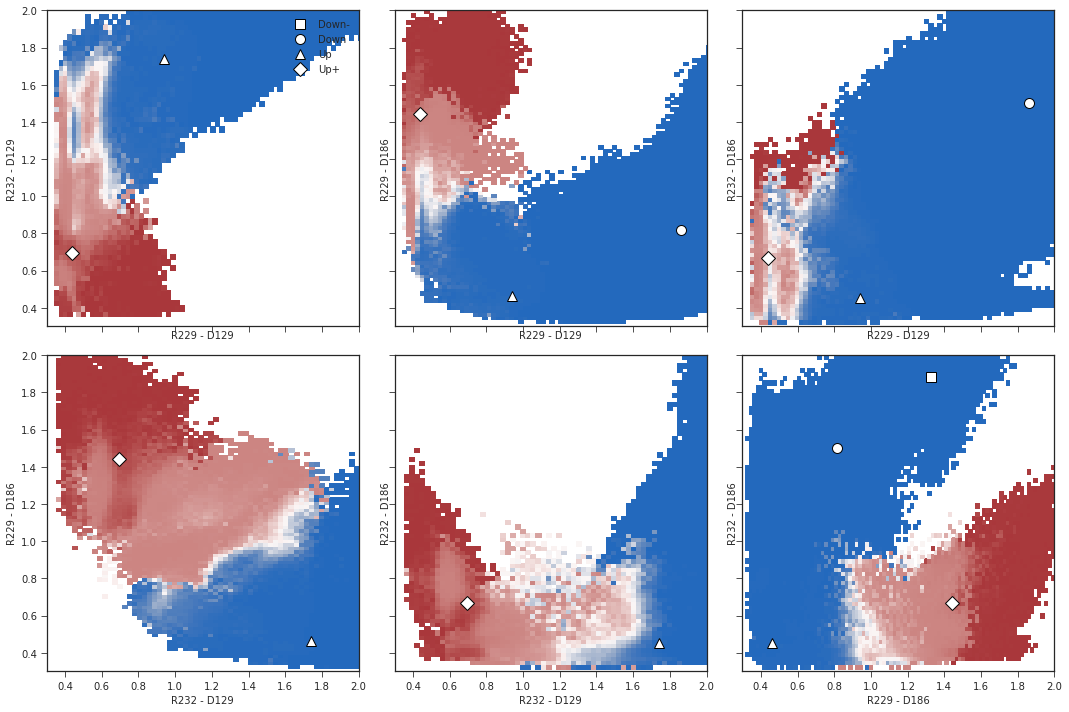

In [43]:
f, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
# 100 ns lag
s = 10
for ((sb1, sb2), ax) in zip(combinations(sb_ids, 2), axes.flat):
    q_dens, xe, ye = np.histogram2d(
        sb_arr[:, sb1], sb_arr[:, sb2], bins=100, density=False, weights=q_arr * com
    )
    w_dens, _, _ = np.histogram2d(
        sb_arr[:, sb1], sb_arr[:, sb2], bins=100, density=False, weights=com
    )
    ax.pcolor(xe, ye, (q_dens / w_dens).T, cmap="vlag")
    ax.set(xlabel=sb_labels[sb1 - 30], ylabel=sb_labels[sb2 - 30])

axes[0][0].set(xlim=[0.3, 2.0], ylim=[0.3, 2.0])
util.plot_models(axes[0][0], feat2_models[:, 48:55:6])  # indexes 48 and 54
util.plot_models(axes[0][1], feat2_models[:, 48:54:5])  # 48 and 53
util.plot_models(axes[0][2], feat2_models[:, 48:60:11])  # 48 and 59
util.plot_models(axes[1][0], feat2_models[:, 54:52:-1])  # indexes 54 and 53
util.plot_models(axes[1][1], feat2_models[:, 54:60:5])  # 54 and 59
util.plot_models(axes[1][2], feat2_models[:, 53:60:6])  # 53 and 59
axes[0][0].legend(["Down-", "Down", "Up", "Up+"])

f.tight_layout()

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


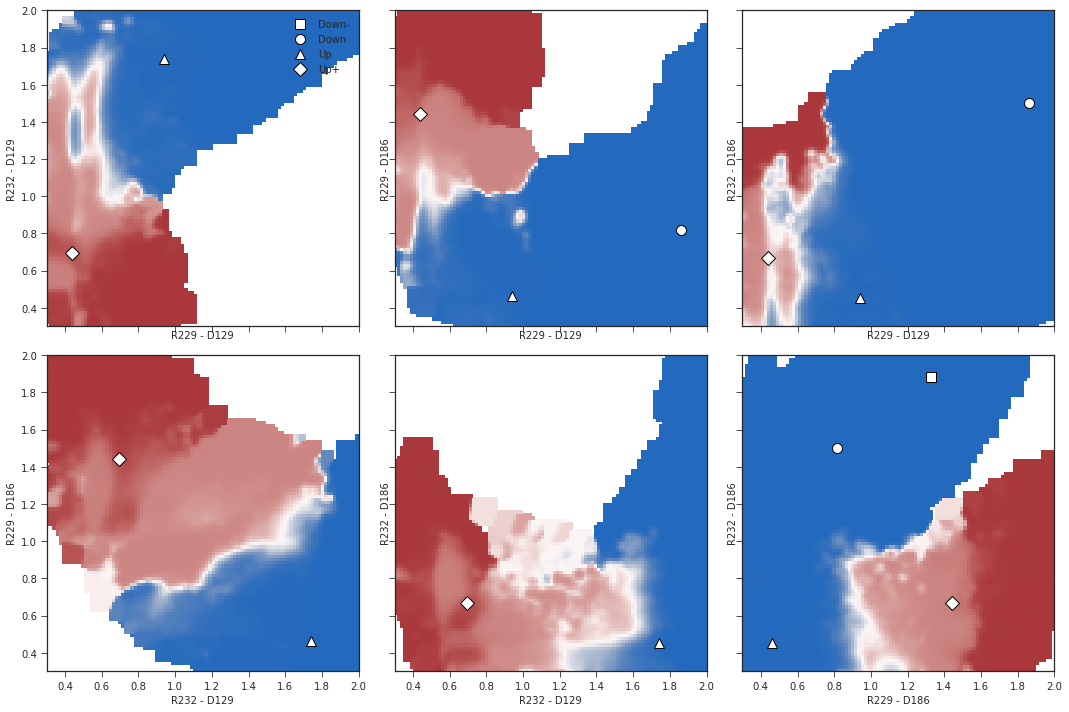

In [47]:
f, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
# 100 ns lag
s = 10
for ((sb1, sb2), ax) in zip(combinations(sb_ids, 2), axes.flat):
    q_dens, xe, ye = kde.kdesum2d(
        sb_arr[:, sb1],
        sb_arr[:, sb2],
        q_arr * com,
        xmin=0.3,
        xmax=2.0,
        ymin=0.3,
        ymax=2.0,
    )
    w_dens, _, _ = kde.kdesum2d(
        sb_arr[:, sb1], sb_arr[:, sb2], com, xmin=0.3, xmax=2.0, ymin=0.3, ymax=2.0
    )
    ax.pcolor(xe, ye, (q_dens / w_dens).T, cmap="vlag")
    ax.set(xlabel=sb_labels[sb1 - 30], ylabel=sb_labels[sb2 - 30])

axes[0][0].set(xlim=[0.3, 2.0], ylim=[0.3, 2.0])
util.plot_models(axes[0][0], feat2_models[:, 48:55:6])  # indexes 48 and 54
util.plot_models(axes[0][1], feat2_models[:, 48:54:5])  # 48 and 53
util.plot_models(axes[0][2], feat2_models[:, 48:60:11])  # 48 and 59
util.plot_models(axes[1][0], feat2_models[:, 54:52:-1])  # indexes 54 and 53
util.plot_models(axes[1][1], feat2_models[:, 54:60:5])  # 54 and 59
util.plot_models(axes[1][2], feat2_models[:, 53:60:6])  # 53 and 59
axes[0][0].legend(["Down-", "Down", "Up", "Up+"])

f.tight_layout()

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


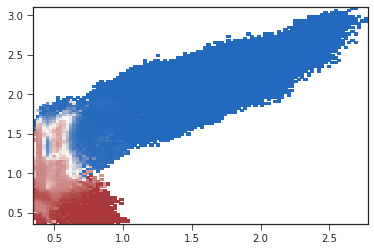

In [39]:
sb1 = 48
sb2 = 54
f = plt.figure()
ax = f.add_subplot(111)
q_dens, xe, ye = np.histogram2d(
    sb_arr[:, sb1], sb_arr[:, sb2], bins=100, density=False, weights=q_arr * com
)
w_dens, _, _ = np.histogram2d(
    sb_arr[:, sb1], sb_arr[:, sb2], bins=100, density=False, weights=com
)
ax.pcolor(xe, ye, (q_dens / w_dens).T, cmap="vlag")

In [ ]:
np.histogramdd()

# Try merging some clusters/indicator functions

In [47]:
# split trajectories
dtraj_list = np.split(dtrajs, traj_inds)

In [50]:
# calculate transition matrix with lag = 2000 (200 ns)
lag = 2000
T = pyemma.msm.estimate_markov_model(dtrajs, lag, reversible=True).transition_matrix

In [52]:
# reduce to 250 clusters
pcca = pyemma.msm.PCCA(T, 250)

KeyboardInterrupt: 

In [ ]:
pcca.metastable_sets

Doesn't really work since it takes too long to assign 250 clusters